In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import math

from converter import CostNormalization

# Partie Rémy CAZABET

# But de l'analyse

Dans ce notebook, nous allons partir d'un jeu de données recessant des montagnes russes afin de voir si nous parvenons à prédire le prix de construction d'un manège de parc d'attraction à l'aide de machine learning.

In [3]:
df = pd.read_csv("coaster_db.csv", sep = ',')

## Exploration du jeu de donnée initial

Le jeu de données contient un total de 1087 montagnes russes et un total de 56 variables (longueur, hauteur, vitesse, etc...).
Le jeu de donnée initial est assez riche. Cependant il semble avoir été crée à partir de différente source. Par conséquent le format des données est inconsistant entre les différents manèges et certaines informations ne sont remplis que pour une partie d'entre eux.
Nous avons donc décider de conserver les colonnes présentant moins de 20% de NaN.

In [4]:
keep = []
for col in df.columns:
    if df[col].isnull().sum() <= 0.2*len(df):

        keep.append(col)

keep

# Premier filtre sur les colonnes. On garde les colonnes qui possèdes moins de 20% de NaN



['coaster_name',
 'Length',
 'Speed',
 'Location',
 'Status',
 'Type',
 'Manufacturer',
 'Height',
 'Inversions',
 'year_introduced',
 'Type_Main',
 'speed1',
 'speed2',
 'speed1_value',
 'speed1_unit',
 'speed_mph',
 'height_value',
 'height_unit',
 'Inversions_clean']

In [5]:
keep = ["coaster_name", 
"Length",
"Speed", 
"Type",
"Manufacturer",
"Height",
"Inversions_clean",
"Cost",
"year_introduced"]
df = df[keep]

Nous avons ensuite réfléchis au catégorie les plus pertinentes pour réaliser une analyse. Notre choix finale c'est porté sur les information concernant la taille, la vitesse, la fabrication ou encore l'année de création.

In [6]:
df = df.dropna()


In [7]:
df.columns

Index(['coaster_name', 'Length', 'Speed', 'Type', 'Manufacturer', 'Height',
       'Inversions_clean', 'Cost', 'year_introduced'],
      dtype='object')

Données concernant la longueur de l'attraction
Le jeu de donnée contient des longueurs en système métrique et impérial. Nous avons donc décider de convertir toutes les longueurs au format métrique avec deux chiffres après la virgule

In [8]:
# Change length columns
list_length = []

for i in df["Length"]:
    length = i.split('(')[1].split(')')[0]
    if length[len(length)-1] == 'm':
        length = float(length[:len(length)-2].replace(',', ''))
        list_length.append(round(length, 2))
    
    elif length[len(length)-1] == 't':
        length = float(length[:len(length)-3].replace(',', '')) * 0.3048
        list_length.append(round(length, 2))
        
df["Length"] = list_length

## Données concernant la hauteur de l'attraction
La problématique est la même que précédemment. Nous avons encore une fois choisi d'utilisé le système métrique.

In [9]:
# Change Height columns
liste_height = []

for i in df["Height"]:
    height = i.split('(')[1].split(')')[0]
    if height[len(height)-1] == 'm':
        height = float(height[:len(height)-2].replace(',', ''))
        liste_height.append(round(height, 2))
    
    elif height[len(height)-1] == 't':
        height = float(height[:len(height)-3].replace(',', '')) * 0.3048
        liste_height.append(round(height, 2))

df["Height"] = liste_height

## Données concernant la vitesse de l'attraction
On a des vitesses en mph et en km/h, on a tout passé en km/h

In [10]:
# Change speed columns
list_speed = []
for speed in df["Speed"].tolist():
    speed = speed.split('(')[1].split(')')[0]
    speed = speed.split(' ')
    if speed[1] == 'mph':
        value = float(speed[0])*1.60934
        list_speed.append(round(value,1))
    if speed[1] == 'km/h':
        value = float(speed[0])
        list_speed.append(value)
df["Speed"] = list_speed

## Données concernant le matériau de l'attraction
On a des données en chaine de caractère. On les a donc numéralisées et binarisées pour que l'algorithme de machine learning puisse les prendre en compte.

In [11]:
list_type = []

# Change la colonne Type en 0 (Bois) ou 1 (Acier)
for i in df["Type"].values:
    list_type.append(0 if (i.split("\xa0")[0] == "Wood") else 1)

df["Type"] = list_type

## Données concernant le coût de l'attraction
Cette fois ci, nous avons à faire à des données qui ne sont pas du tout harmonisées. Nous avons des valeurs numériques, des chaines de caractères explicites (15 millions au lieu de 15000000, etc...) mais également des monnaies différentes (euros, dollars, yen, couronnes danoises, etc...). Nous avons donc tout passé en dollars pour la suite.

In [12]:
# Installation 

!pip install currencyconverter
!pip install cpi

In [13]:
from currency_converter import CurrencyConverter
c = CurrencyConverter()

In [14]:
df["Cost"] = CostNormalization(df)

In [15]:
df = df.drop_duplicates("coaster_name")

On s'est rendu compte que le jeu de donnée avait des lignes dupliquées donc on les enlève

In [16]:
df = df[df["Cost"] != float('inf')]

In [17]:
df["Cost"].describe()

count    3.250000e+02
mean     1.044818e+07
std      1.980831e+07
min      2.000000e+00
25%      2.063111e+06
50%      6.251852e+06
75%      1.300000e+07
max      3.000000e+08
Name: Cost, dtype: float64

Etant donné que notre jeu de données contient des instances de montagne russes qui datent de 1910, il est nécessaire (si on veut prédire le prix) de prendre en compte l'inflation. On va donc utiliser le package cpi et tout passer en dollars d'aujourd'hui. Evidemment cela peut entrainer un biais.

In [18]:
import cpi

C:\Users\marti\anaconda3\lib\site-packages\cpi\__init__.py:42: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  warnings.warn(StaleDataWarning())


In [19]:
money = df["Cost"].values
year = df["year_introduced"].values

# Correction de l'inflation
inflated_adjusted = []
for i in range(len(money)):
    if year[i] < 2022 and year[i] > 1910:
        inflated_adjusted.append(cpi.inflate(money[i], year[i]))
    elif year[i] == 1910:
        inflated_adjusted.append(cpi.inflate(money[i], 1913))
    
    else:
        inflated_adjusted.append(money[i])

In [20]:
df["Cost"] = inflated_adjusted

# Prediction

On va donc essayer de prédire, par une approche de machine learning, le prix que couterait une attraction à construire en fonction de différents paramètres (longueur, vitesse, taille, nombre de loopings et l'année de construction). On a essayé de prendre en compte les matériaux utilisés mais ça nous générait plus d'erreur donc nous avons retiré cette variable. On va essayer 3 algorithmes différents : Decision tree, random forest et MLP. Pour calculer l'efficacité d'un algo, on va se baser sur la moyenne des carrés des écarts à la moyenne.

## Decision Tree

In [21]:
from sklearn.model_selection import train_test_split

target = df["Cost"]
df_X = df[["Length","Speed", "Height", "Inversions_clean", "year_introduced"]]
Xtrain,Xtest,Ytrain,Ytest = train_test_split(df_X,target, random_state = 1)

In [22]:
from sklearn.tree import DecisionTreeRegressor

# Créer un classifieur en utilisant l'algorithme d'arbre de décision
clf = DecisionTreeRegressor(random_state=1)

# Entraîner le classifieur en utilisant les données d'entraînement
clf = clf.fit(Xtrain, Ytrain)

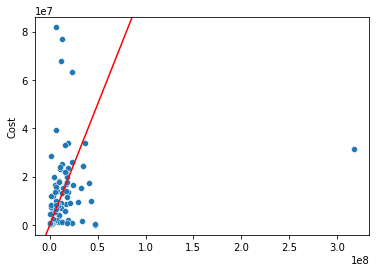

In [23]:
predict = clf.predict(Xtest)
graph = sns.scatterplot(x = predict, y = Ytest)
graph.axline(xy1 = [0, 0], slope = 1, color= "red")

In [24]:
from sklearn.metrics import mean_squared_error

In [25]:
mse_DT = math.sqrt(mean_squared_error(Ytest, predict))
mse_DT

36726152.63359254

En moyenne, on se trompe de 37 millions de dollars dans la prédiction

## Random forest

In [26]:
from sklearn.ensemble import RandomForestRegressor

In [27]:
# Créer un classifieur en utilisant l'algorithme d'arbre de décision
rfr = RandomForestRegressor(random_state = 1)

# Entraîner le classifieur en utilisant les données d'entraînement
rfr = rfr.fit(Xtrain, Ytrain)

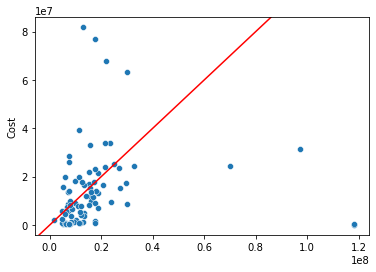

In [28]:
predict2 = rfr.predict(Xtest)

graph = sns.scatterplot(x = predict2, y = Ytest)
graph.axline(xy1 = [0, 0], slope = 1, color= "red")

In [29]:
mse_RF = math.sqrt(mean_squared_error(Ytest, predict2))
mse_RF

25134463.670611624

On se trompe en moyenne de 25 millions de dollars

## MLP

On va chercher dans un premier temps la structure de réseau de neurone qui minimise la mean squared error

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

mlpr = MLPRegressor(random_state = 1)

dico = {"hidden_layer_sizes" : ((10,100), (50,100), 
                                (100,100), (10,10,100), 
                                (10, 50, 100), (50,10,100),
                                (10,100,100), (100, 10, 100),
                                (50, 50, 100), (100, 50, 100),
                               (50, 100, 100), (100, 100, 100))}

gs = GridSearchCV(mlpr, dico, scoring="neg_mean_squared_error")
gs.fit(Xtrain, Ytrain)

C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multi

C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multi

GridSearchCV(estimator=MLPRegressor(random_state=1),
             param_grid={'hidden_layer_sizes': ((10, 100), (50, 100),
                                                (100, 100), (10, 10, 100),
                                                (10, 50, 100), (50, 10, 100),
                                                (10, 100, 100), (100, 10, 100),
                                                (50, 50, 100), (100, 50, 100),
                                                (50, 100, 100),
                                                (100, 100, 100))},
             scoring='neg_mean_squared_error')

In [31]:
gs.best_params_

{'hidden_layer_sizes': (100, 100, 100)}

Best params = 100,100, 100

In [32]:
mlpr = MLPRegressor((100, 100, 100), random_state = 1)
mlpr = mlpr.fit(Xtrain, Ytrain)
predict3 = mlpr.predict(Xtest)

C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


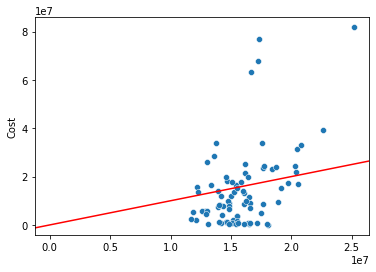

In [33]:
graph = sns.scatterplot(x = predict3, y = Ytest)
graph.axline(xy1 = [0, 0], slope = 1, color= "red")

In [34]:
mse_MLP = math.sqrt(mean_squared_error(Ytest, predict3))
mse_MLP

15335959.351141172

Pour l'instant on arrive au mieux à se tromper de 15 millions de dollars en moyenne

# Detection d'outliers
Lorsque l'on regarde les plots, on se rend compte qu'on prédit globalement bien les prix mais qu'on a des valeurs qu'on prédit très mal. On va donc essayer de détecter des outliers dans nos données (on considérera qu'il y a 1% d'outliers).

In [35]:
from sklearn.ensemble import IsolationForest

isf = IsolationForest(random_state = 1, contamination = 0.01)

isf = isf.fit(Xtrain, Ytrain)

test = isf.fit_predict(df_X)

for i in range(len(test)):
    if test[i] == -1:
        target = target.drop(target.index[i], axis = 0)
        df_X = df_X.drop(df_X.index[i], axis = 0)

In [36]:
Xtrain,Xtest,Ytrain,Ytest = train_test_split(df_X,target, random_state = 1)

## Decision tree

In [37]:
from sklearn.tree import DecisionTreeRegressor

# Créer un classifieur en utilisant l'algorithme d'arbre de décision
clf = DecisionTreeRegressor(random_state=1)

# Entraîner le classifieur en utilisant les données d'entraînement
clf = clf.fit(Xtrain, Ytrain)

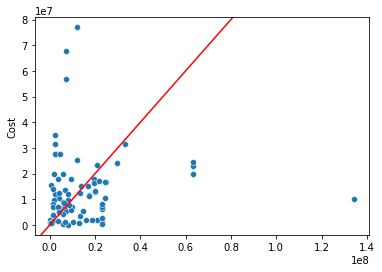

In [38]:
predict = clf.predict(Xtest)
graph = sns.scatterplot(x = predict, y = Ytest)
graph.axline(xy1 = [0, 0], slope = 1, color= "red")

In [39]:
mse_DT2 = math.sqrt(mean_squared_error(Ytest, predict))
mse_DT2

22448831.233870704

## Random forest

In [40]:
# Créer un classifieur en utilisant l'algorithme d'arbre de décision
rfr = RandomForestRegressor(random_state = 1)

# Entraîner le classifieur en utilisant les données d'entraînement
rfr = rfr.fit(Xtrain, Ytrain)

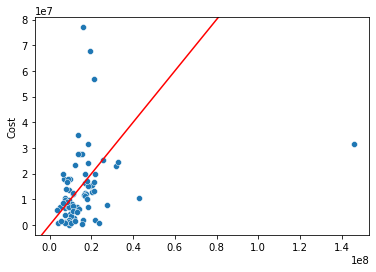

In [41]:
predict2 = rfr.predict(Xtest)

graph = sns.scatterplot(x = predict2, y = Ytest)
graph.axline(xy1 = [0, 0], slope = 1, color= "red")

In [42]:
mse_RF2 = math.sqrt(mean_squared_error(Ytest, predict2))
mse_RF2

18259431.171626214

## MLP

In [43]:
mlpr = MLPRegressor(random_state = 1)

dico = {"hidden_layer_sizes" : ((10,100), (50,100), 
                                (100,100), (10,10,100), 
                                (10, 50, 100), (50,10,100),
                                (10,100,100), (100, 10, 100),
                                (50, 50, 100), (100, 50, 100),
                               (50, 100, 100), (100, 100, 100))}

gs = GridSearchCV(mlpr, dico, scoring="neg_mean_squared_error")
gs.fit(Xtrain, Ytrain)

C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multi

C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multi

GridSearchCV(estimator=MLPRegressor(random_state=1),
             param_grid={'hidden_layer_sizes': ((10, 100), (50, 100),
                                                (100, 100), (10, 10, 100),
                                                (10, 50, 100), (50, 10, 100),
                                                (10, 100, 100), (100, 10, 100),
                                                (50, 50, 100), (100, 50, 100),
                                                (50, 100, 100),
                                                (100, 100, 100))},
             scoring='neg_mean_squared_error')

In [44]:
gs.best_params_

{'hidden_layer_sizes': (100, 100, 100)}

In [45]:
mlpr = MLPRegressor((100, 100, 100), random_state = 1)
mlpr = mlpr.fit(Xtrain, Ytrain)
predict3 = mlpr.predict(Xtest)

C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


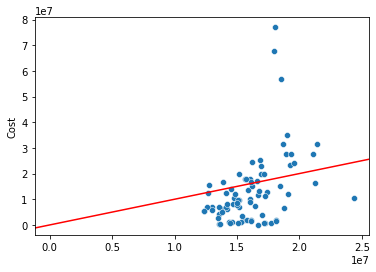

In [46]:
graph = sns.scatterplot(x = predict3, y = Ytest)
graph.axline(xy1 = [0, 0], slope = 1, color= "red")

In [47]:
mse_MLP2 = math.sqrt(mean_squared_error(Ytest, predict3))
mse_MLP2

13231288.702200947

In [48]:
recap = pd.DataFrame({"Decision Tree" : [mse_DT, mse_DT2],
                     "Random Forest" : [mse_RF, mse_RF2],
                     "MLP" : [mse_MLP, mse_MLP2]})
recap.index = ("With ouliers", "Without outliers")
recap

Decision Tree  Random Forest           MLP
With ouliers       3.672615e+07   2.513446e+07  1.533596e+07
Without outliers   2.244883e+07   1.825943e+07  1.323129e+07

On arrive à prédire le prix en se trompant en moyenne de 13.2 millions d'euros. C'est une marge d'erreur assez importante ce qui nous fait nous questionner sur la pertinence des variables utilisées pour prédire le prix. En effet, ce qui joue beaucoup dans le prix d'une montagne russe est surtout tout ce qui est autour du circuit (les décors, les automates, etc...) et moins sa taille, sa hauteur ou son nombre de looping (voir plots ci dessous).

C:\Users\marti\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


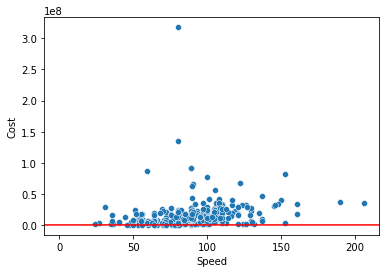

In [49]:
graph = sns.scatterplot(df.Speed, df.Cost)
graph.axline(xy1 = [0, 0], slope = 1, color= "red")

C:\Users\marti\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


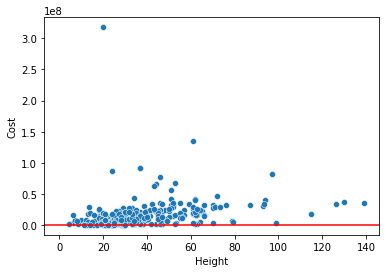

In [50]:
graph = sns.scatterplot(df.Height, df.Cost)
graph.axline(xy1 = [0, 0], slope = 1, color= "red")

C:\Users\marti\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


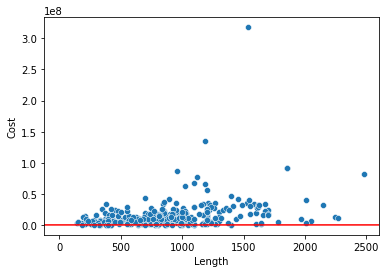

In [51]:
graph = sns.scatterplot(df.Length, df.Cost)
graph.axline(xy1 = [0, 0], slope = 1, color= "red")

C:\Users\marti\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Inversions_clean', ylabel='Cost'>

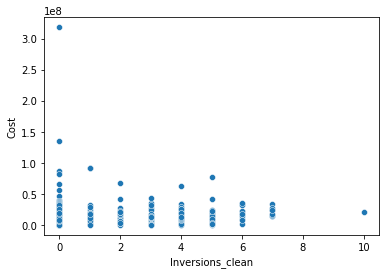

In [52]:
sns.scatterplot(df.Inversions_clean, df.Cost)

On a néanmoins essayé d'optimiser notre algorithme de prédiction. On a testé plusieurs approches (decision tree, random forest et MLP) et en enlevant des outliers. On trouve qu'enlever les outliers diminue systématiquement, et peut importe l'algorithme utilisé, les erreurs. De plus, dans notre cas, l'approche qui réduit le plus l'erreur est l'approche par réseau de neurone (MLP). On obtient une erreur moyenne plus faible que l'écart-type des prix dans notre dataframe (13 millions contre 23 millions).

# Partie DE MARCHI

## Discrétisation des données

Afin de détecter des patterns dans nos données, il est nécessaire de les discrétiser car nous avons une majorité de données continues.

### Vitesse de l'attraction


Concernant la vitesse, nous l'avons divisée en 3 catégories en se basant sur les quartiles (Slow = inférieur au premier quartile, Fast = supérieur au 3e quartile)

In [60]:
df["Slow"] = [1 if Speed < 72 else 0 for Speed in df["Speed"]]
df["Normal"] = [1 if Speed >72 and Speed < 101 else 0 for Speed in df["Speed"]]
df["Fast"] = [1 if Speed >= 101 else 0 for Speed in df["Speed"]]

### Looping

Nous avons binarisé cette colonne (absence ou présence de looping)

In [61]:
df["Looping"] = [1 if Looping > 0 else 0 for Looping in df["Inversions_clean"]]

### Longueur de l'attraction

On a binarisé les données par rapport à la médiane

In [62]:
df["Short"] = [1 if Length < 850 else 0 for Length in df["Length"]]
df["Long"] = [1 if Length >= 850 else 0 for Length in df["Length"]]

### Hauteur de l'attraction

On a binarisé les données par rapport à la médiane

In [63]:
df["Small"] = [1 if Height < 33 else 0 for Height in df["Height"]]
df["Tall"] = [1 if Height >= 33 else 0 for Height in df["Height"]]

### Année de construction

Cette variable a été binarisée en se basant sur la répartition des années dans le jeu de données.
On a considéré que les montagnes russes étaient anciennes si elles avaient été construites avant l'année 2000

<AxesSubplot:xlabel='year_introduced', ylabel='Count'>

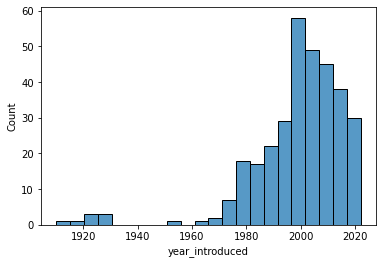

In [64]:
sns.histplot(df["year_introduced"])

In [65]:
df["Old"] = [1 if Year < 2000 else 0 for Year in df["year_introduced"]]
df["Recent"] = [1 if Year >= 2000 else 0 for Year in df["year_introduced"]]

### Prix de l'attraction

Cette variable à été discrétisée en se basant sur les quartiles on a donc 4 catégories :

* x < 1er quartile = Very cheap
* 1er quartile < x < 2e quartile = Cheap
* 2e quartile < x < 3e quartile = Expensive
* x > 3e quartile = Very expensive

In [66]:
df["Very_Cheap"] = [1 if Cost < 3.750450e+06 else 0 for Cost in df["Cost"]]
df["Cheap"] = [1 if Cost >3.750450e+06 and Cost < 9.717636e+06 else 0 for Cost in df["Cost"]]
df["Expensive"] = [1 if Cost >9.717636e+06 and Cost < 1.951765e+07 else 0 for Cost in df["Cost"]]
df["Very_Expensive"] = [1 if Cost >= 1.951765e+07 else 0 for Cost in df["Cost"]]

# DESCRIPTION DU PACKAGE A RAJOUTER

In [71]:
!pip install mlxtend --upgrade --no-deps

  Using cached mlxtend-0.21.0-py2.py3-none-any.whl (1.3 MB)


In [68]:
property_set = df[["Slow","Fast","Normal",
                   "Short","Long",
                   "Small", "Tall",
                   "Looping",
                   "Old","Recent",
                   "Very_Cheap","Cheap","Expensive","Very_Expensive"]].copy()

## Attentes

A priori, on pourrait s'attendre à quelques règles d'associations.

Par exemple, si une attraction est longue, elle sera haute, ou si une attraction est peu chère alors elle sera courte, etc...

In [72]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

frequent_itemsets = apriori(property_set, min_support=0.07, use_colnames=True)

C:\Users\marti\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [73]:
association = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
association.sort_values("confidence", ascending = False)

C:\Users\marti\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


antecedents consequents  antecedent support  \
19            (Very_Cheap, Slow)     (Small)            0.101538   
17                   (Slow, Old)     (Small)            0.110769   
74     (Very_Cheap, Short, Slow)     (Small)            0.083077   
68            (Slow, Old, Short)     (Small)            0.086154   
1                         (Slow)     (Small)            0.230769   
..                           ...         ...                 ...   
42           (Normal, Expensive)    (Recent)            0.144615   
64             (Looping, Recent)      (Tall)            0.267692   
4                        (Short)     (Small)            0.483077   
5                        (Cheap)     (Short)            0.246154   
96  (Fast, Tall, Very_Expensive)    (Recent)            0.123077   

    consequent support   support  confidence      lift  leverage  conviction  
19            0.498462  0.101538    1.000000  2.006173  0.050925         inf  
17            0.498462  0.110769    1.000000  2.006173  0.055555         inf  
74            0.498462  0.083077    1.000000  2.006173  0.041666         inf  
68            0.498462  0.086154    1.000000  2.006173  0.043209         inf  
1             0.498462  0.227692    0.986667  1.979424  0.112663   37.615385  
..                 ...       ...         ...       ...       ...         ...  
42            0.572308  0.101538    0.702128  1.226836  0.018774    1.435824  
64            0.501538  0.187692    0.701149  1.397997  0.053434    1.667929  
4             0.498462  0.338462    0.700637  1.405599  0.097666    1.675352  
5             0.483077  0.172308    0.700000  1.449045  0.053396    1.723077  
96            0.572308  0.086154    0.700000  1.223118  0.015716    1.425641  

[126 rows x 9 columns]

On voit qu'il a des sets qui sont redondants donc on va essayer de ne garder que les sets qui rajoutent de l'information.